In [4]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
import keras
from keras.datasets import boston_housing
from keras import models, activations, layers, losses, metrics
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

print(x_train[0])
print(y_train[0])

# 标准化数据，减去平均值除以标准差
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)

x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

# 由于后面需要多次定义模型，将模型封装到函数中
def build_model():
    model = models.Sequential()
    model.add(layers.Input((13,)))
    model.add(layers.Dense(64, "relu"))
    model.add(layers.Dense(64, "relu"))
    model.add(layers.Dense(1))
    model.compile(
        optimizer="rmsprop",
        loss=losses.mean_squared_error,
        metrics=[metrics.mean_absolute_error]
    )
    return model

import numpy as np

"""
K折验证：
    将数据集拆分为几个分区，实例化K个相同模型，每个模型在K-1个分区上训练，在剩下的一个分区上评估，
    模型的验证分数等于K个验证分数的平均值
    下面以四个分区为例做K折验证
"""
k = 4 # 分区数
num_val_samples = len(x_train) // k # 每个分区的样本数
num_epochs = 500 # 循环次数
mae_history = [] # 保存每一个模型的平均绝对误差值mae

# 这个函数用来拆分验证集和测试集
def getFoldData(i:int):
    val_data = np.zeros((num_val_samples, 13))
    val_targets = np.zeros((num_val_samples,))
    
    val_data = x_train[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = y_train[i*num_val_samples:(i+1)*num_val_samples]
    
    partical_train_data = np.concatenate([x_train[:i*(num_val_samples)], x_train[(i+1)*num_val_samples:]],axis=0)
    partical_train_targets = np.concatenate([y_train[:i*num_val_samples],y_train[(i+1)*num_val_samples:]],axis = 0)
    return (partical_train_data, partical_train_targets), (val_data, val_targets)

# 训练模型
for i in range(k):
    print("processing fold #", i)
    (partical_train_data, partical_train_targets), (val_data, val_targets) = getFoldData(i)
    print(partical_train_data.shape, partical_train_targets.shape)
    print(val_data.shape,val_targets.shape)
    model = build_model()
    history = model.fit(
        partical_train_data,
        partical_train_targets,
        batch_size=1,
        epochs=num_epochs,
        verbose="0",
        validation_data=(val_data, val_targets)
    )
    mae_history.append(history.history["val_mean_absolute_error"])

average_mae_history = [(np.mean([x[i] for x in mae_history])) for i in range(num_epochs)]

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
15.2
processing fold # 0
(303, 13) (303,)
(101, 13) (101,)
Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Ep

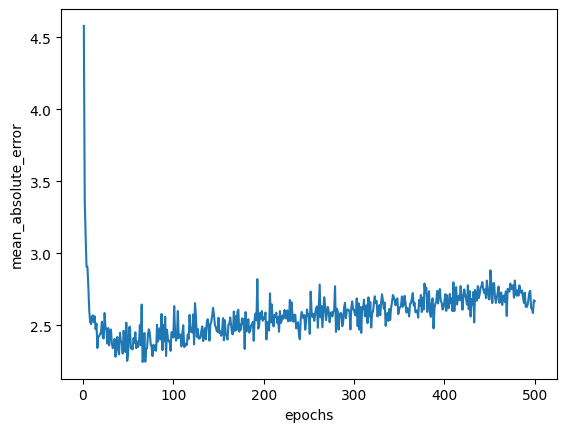

In [5]:
# 将数据可视化
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel("epochs")
plt.ylabel("mean_absolute_error")
plt.show()

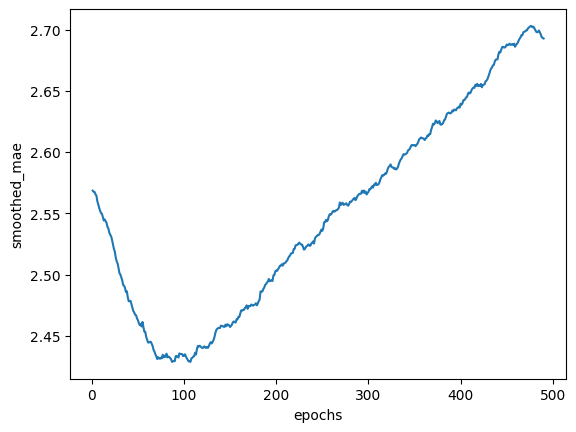

In [11]:
"""
原始数据波动太大没有办法看到实际规律，对数据做如下处理：
    1. 删除前十个数据点，因为这10个数据点不在大多数点的范围内
    2. 将数据点替换为前面数据点的指数移动平均值，平滑曲线
从图中可以看出大约在80轮时模型的误差达不再显著降低，100轮以后误差开始增大，过拟合
"""
def smooth_curve(points, factor = 0.98):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1]*factor + point*(1 - factor))
        else:
            smoothed_points.append(point)
    
    return smoothed_points

smoothed_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smoothed_mae_history)+1), smoothed_mae_history)
plt.xlabel("epochs")
plt.ylabel("smoothed_mae")
plt.show()

In [12]:
# 新建一个模型，在这个模型上使用全部数据集，并使用测试集做测试，迭代80轮
# 最终预测的误差依然有2.52
model = build_model()
model.fit(
    x_train,
    y_train,
    epochs = 90,
    batch_size=16,
    verbose = "0"
)
test_mse, test_mae = model.evaluate(x_test, y_test)
print(test_mae)

Epoch 1/90
Epoch 2/90
Epoch 3/90
Epoch 4/90
Epoch 5/90
Epoch 6/90
Epoch 7/90
Epoch 8/90
Epoch 9/90
Epoch 10/90
Epoch 11/90
Epoch 12/90
Epoch 13/90
Epoch 14/90
Epoch 15/90
Epoch 16/90
Epoch 17/90
Epoch 18/90
Epoch 19/90
Epoch 20/90
Epoch 21/90
Epoch 22/90
Epoch 23/90
Epoch 24/90
Epoch 25/90
Epoch 26/90
Epoch 27/90
Epoch 28/90
Epoch 29/90
Epoch 30/90
Epoch 31/90
Epoch 32/90
Epoch 33/90
Epoch 34/90
Epoch 35/90
Epoch 36/90
Epoch 37/90
Epoch 38/90
Epoch 39/90
Epoch 40/90
Epoch 41/90
Epoch 42/90
Epoch 43/90
Epoch 44/90
Epoch 45/90
Epoch 46/90
Epoch 47/90
Epoch 48/90
Epoch 49/90
Epoch 50/90
Epoch 51/90
Epoch 52/90
Epoch 53/90
Epoch 54/90
Epoch 55/90
Epoch 56/90
Epoch 57/90
Epoch 58/90
Epoch 59/90
Epoch 60/90
Epoch 61/90
Epoch 62/90
Epoch 63/90
Epoch 64/90
Epoch 65/90
Epoch 66/90
Epoch 67/90
Epoch 68/90
Epoch 69/90
Epoch 70/90
Epoch 71/90
Epoch 72/90
Epoch 73/90
Epoch 74/90
Epoch 75/90
Epoch 76/90
Epoch 77/90
Epoch 78/90
Epoch 79/90
Epoch 80/90
Epoch 81/90
Epoch 82/90
Epoch 83/90
Epoch 84/90
E

In [ ]:
"""
小结：
    1.回归问题和分类问题不同，使用的损失函数为均方误差（mse）
    2.回归问题使用的回归指标，常见的是平均绝对误差(mae)
    3.输入特征如果具有不同的取值范围，应该先进行预处理，对每个特征单独进行缩放（标准化）
    4.可用数据很少时，使用K折验证可以评估模型，并且隐藏层要少，使用小型网络避免严重过拟合
"""

In [13]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((404, 13), (404,), (102, 13), (102,))